# Text Recognition Model: Training and Tuning

> NOTE: This sample notebook has been executed in a laptop without a GPU, hence the bad results.

In [1]:
from tfgpkg.recognition import DataUnpack, DataGen
from tfgpkg.recognition.word import StringVectorizer, RecognitionNet, Arch
from tfgpkg.recognition.datagen import DataGen
from tensorflow import keras

from shutil import make_archive, rmtree as rm_dir
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import h5py as h5
import cv2
import os

In [2]:
tf.__version__

'2.2.0'

In [2]:
MAX_WORD_LENGTH = 34  # 24

width, height = TARGET_SIZE = (256, 64)  # (192, 48)
IMAGE_RATIO = width / height
print(IMAGE_RATIO)

4.0


### Data and Model Loading

In [6]:
mini_dataset_dir = "../../data-sources/minified/" # 'iam.h5', 'rimes2011.h5', 'spanish-words-mini.h5', 'spanish.h5'
dataset_dest_dir = TemporaryDirectory(prefix="htr_").name

save_to_disk = False

train_spa, test_spa, valid_spa = DataUnpack.unpack(
    f"{mini_dataset_dir}/spanish.h5",
    dest_dir=dataset_dest_dir,
    color=False,
    save_to_disk=save_to_disk,  # if the dataset is quite big or not enough ram
    target_size=TARGET_SIZE,
    aspect_ratio=IMAGE_RATIO
)

if save_to_disk:
    print(f"Unpacking dataset to {dataset_dest_dir}")

In [9]:
print(train_spa[0].shape, train_spa[1].shape)

(396, 256, 64, 1) (396,)


In [3]:
train_logdir = "training_logs"
os.makedirs(train_logdir, exist_ok=True)

net = RecognitionNet(
    logdir=train_logdir,
    input_size=(*TARGET_SIZE, 1)
    # arch=Arch.Gated
    # charset=RecognitionNet.LATIN_CHAR
)

In [5]:
# net.model.summary()

In [ ]:
# remove the temporal directory in the end
if save_to_disk:
    rm_dir(dataset_dest_dir)

### Data Augmentation

In [7]:
BATCH_SIZE = 32

train_opts = dict(width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2, shear_range=0.2)

train_gen, test_gen, valid_gen = DataGen(train_spa, test_spa, valid_spa, train_opts).from_tuple(BATCH_SIZE)

### Train the model

In [ ]:
train_gen.reset()
valid_gen.reset()

In [8]:
%%time

EPOCHS = 20

training_results = net.model.fit(
    train_gen,
    steps_per_epoch=train_gen.n // BATCH_SIZE,
    validation_data=valid_gen,
    validation_steps=valid_gen.n // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=net.callbacks,
    verbose=1
)

Epoch 1/20
12/12 [==============================] - 15s 1s/step - loss: 67.4687 - val_loss: 52.8600 - lr: 0.0010
Epoch 2/20
12/12 [==============================] - 14s 1s/step - loss: 27.3092 - val_loss: 31.9111 - lr: 0.0010
Epoch 3/20
12/12 [==============================] - 12s 1s/step - loss: 21.6931 - val_loss: 42.0558 - lr: 0.0010
Epoch 4/20
12/12 [==============================] - 13s 1s/step - loss: 20.4408 - val_loss: 25.7551 - lr: 0.0010
Epoch 5/20
12/12 [==============================] - 12s 1s/step - loss: 20.0058 - val_loss: 27.7296 - lr: 0.0010
Epoch 6/20
12/12 [==============================] - 12s 967ms/step - loss: 19.4122 - val_loss: 26.5105 - lr: 0.0010
Epoch 7/20
12/12 [==============================] - 12s 1s/step - loss: 20.1827 - val_loss: 27.2033 - lr: 0.0010
Epoch 8/20
12/12 [==============================] - 13s 1s/step - loss: 19.3412 - val_loss: 29.6850 - lr: 0.0010
Epoch 9/20
12/12 [==============================] - 13s 1s/step - loss: 19.1662 - val_loss: 2

#### Check the statistics

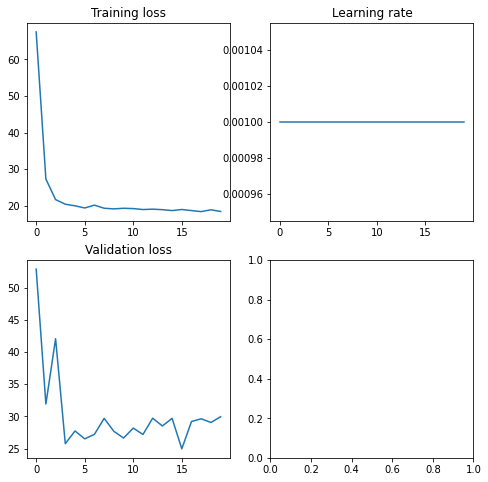

In [9]:
_, axes = plt.subplots(2,2, figsize=(8,8))
axes = axes.flatten()

axes[0].plot(training_results.history["loss"])
axes[0].set_title("Training loss")

axes[1].plot(training_results.history["lr"])
axes[1].set_title("Learning rate")

axes[2].plot(training_results.history["val_loss"])
axes[2].set_title("Validation loss")

plt.show()

#### Compute the WER and CER

In [97]:
test_gen.reset()

predictions, _ = net.predict(
    test_gen.x,
    # steps=train_gen.n // BATCH_SIZE,
    # batch_size=BATCH_SIZE,
    verbose=1
)

print(f"\n{len(predictions)}")

predictions = np.array(predictions).reshape(111, -1)

Model Predict
1/1 [==============================] - 0s 999us/step
CTC Decode
1/1 [==============================] - 0s 94ms/step

111


In [103]:
true_labels = [vectorizer.decode(encoded_vector) for encoded_vector in test_gen.y]
pred_labels = [vectorizer.decode(encoded_vector) for encoded_vector in predictions]

In [105]:
RecognitionNet.compute_cer(true_labels, pred_labels) # the closer to 1.0, the worse

1.0

In [ ]:
wer_results = [RecognitionNet.compute_wer(t, p) for t, p in zip(true_labels, pred_labels)]

print(np.mean(wer_results))

# the closer to 0.0, the better

#### Evaluate the test dataset

In [26]:
test_gen.reset()

net.model.evaluate(
    test_gen,
    steps=train_gen.n // BATCH_SIZE,
    batch_size=BATCH_SIZE,
    verbose=1
)

12/12 [==============================] - 2s 142ms/step - loss: 29.4174


#### Test a network prediction

In [10]:
test_gen.reset()
test_batch = test_gen.next()

(32, 256, 64, 1) (32, 34)
México


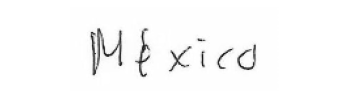

In [14]:
from keras.preprocessing.image import load_img, img_to_array

vectorizer = StringVectorizer()

print(test_batch[0].shape, test_batch[1].shape)

sample_idx = np.random.randint(BATCH_SIZE)

test_vector = test_batch[1][sample_idx, :]
print(vectorizer.decode(test_vector))

test_image = test_batch[0][sample_idx,:,:,0]
plt.imshow(test_image.transpose(), cmap="gray")
plt.axis("off")
plt.show()

In [22]:
test_image_pred = np.expand_dims(test_image, axis=[0,-1])

preds, probs = net.predict(test_image_pred)

In [23]:
vector = list(preds[0][0])

predicted_text = vectorizer.decode(vector)

print(predicted_text)

a


### Save the trained model to `protobuf` (portable) format

In [113]:
trained_model_dir = "trained_models"
trained_model_name = "gated_spanish"

os.makedirs(trained_model_dir, exist_ok=True)

net.model.save(f"./{trained_model_dir}/{trained_model_name}_{EPOCHS}e")
make_archive(
    f"./{trained_model_dir}/{trained_model_name}_{EPOCHS}e",
    "zip",
    f"./{trained_model_dir}/{trained_model_name}_{EPOCHS}e/"
)

'C:\\Users\\Pachacho\\Documents\\TFG_2020\\src\\packages\\playground\\trained_models\\gated_spanish_20e.zip'